# DU-PGD法 (最小二乗問題)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [14]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Convex, SCS

### 準備 (グローバル定数の設定)

In [15]:
n = 10
m = 20
num_itr = 25
K = 200
adam_lr = 3e-3
max_inner = 40

A = randn(m,n)
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 1/λmax

0.017983790216994925

### ミニバッチ生成関数

In [16]:
function mini_batch(K)
    x = Variable(n)
    cons = [x >= -1, x <= 1]
    y_batch = zeros(m,K)
    sol_batch = zeros(n,K)
    for i in 1:K
        y = randn(m)
        y_batch[:,i] = y
        obj = 0.5*sumsquares(A*x-y)
        problem = minimize(obj, cons)
        solve!(problem, SCS.Optimizer; silent_solver = true)
        sol_batch[:,i] = evaluate(x)
    end
    return y_batch, sol_batch
end

mini_batch (generic function with 1 method)

### 射影関数

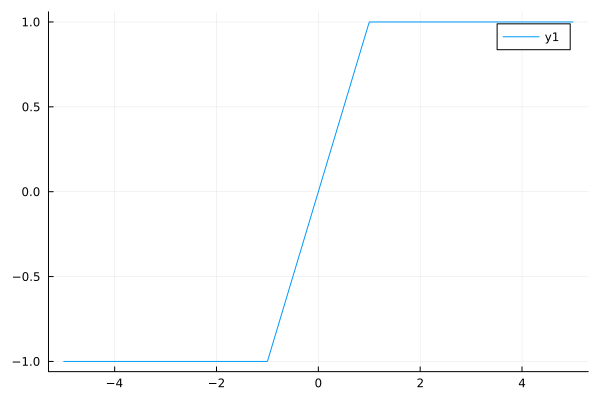

In [17]:
plot(hardtanh)

### 固定ステップサイズの射影勾配法法

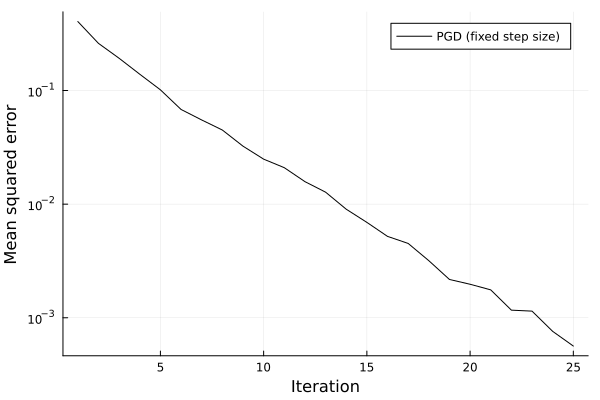

In [18]:
function ProjectedGD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
        x = hardtanh.(x)
    end
    return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = ProjectedGD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="PGD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-PGD反復の定義 

In [19]:
function DU_ProjectedGD(max_itr, y, η)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - η[i]*A'*(A*x - y)
        x = hardtanh.(x)
    end
    return x
end

DU_ProjectedGD (generic function with 1 method)

### 損失関数の定義

In [20]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [21]:
function train(opt, η)
    ps = Flux.params(η) 
    for itr in 1:num_itr 
        for i in 1:max_inner 
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do 
                x_hat = DU_ProjectedGD(itr, y, η)
                loss(x_opt, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_opt = mini_batch(K)
        x̂ = DU_ProjectedGD(itr, y, η)
        println(itr, " ", loss(x_opt, x̂))
    end
end

train (generic function with 1 method)

### DU-PGDのMSE評価用関数

In [22]:
function comp_mse_DUGD(max_itr, η)
    y, x_opt = mini_batch(K)
    x̂ = DU_ProjectedGD(max_itr, y, η)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程

In [ ]:
η_train = zeros(num_itr)
opt = ADAM(adam_lr)
train(opt, η_train)
DUGD_mse =[comp_mse_DUGD(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-PGD", color=:black, marker=:o)

1 0.2643753109555596
2 0.10849491102035305
3 0.03421074020931186
4 0.012335558062469281
5 0.003870055335070493
6 0.0009082656981293216
7 0.006219796258794702
8 0.0008828427866576649
9 6.105906235127532e-5
10 7.43496948014687e-6
11 1.6670111594167695e-6
12 3.740074326614953e-7
13 8.080148590496005e-7
14 3.0591282656107614e-8
15 1.0746865073405608e-8
16 5.103882060330918e-9
17 5.82847002055733e-7
18 2.6352954161931085e-7
19 1.6549208847600373e-7


In [ ]:
savefig("DU-PGD.pdf")

In [ ]:
plot(1:num_itr, η_train, xlabel="Iteration", legend=false, color=:black)

In [ ]:
savefig("DU-PGD-param.pdf")